### Import Necessary Dependencies

In [ ]:
import numpy as np # Optimizing matrix operations
import matplotlib.pyplot as plt # Data Visualization
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose, Activation, BatchNormalization, ReLU, Concatenate, add, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint # Save the model weights according to validation dataset
from tensorflow.keras.datasets import cifar100, cifar10 # Required Datasets Used in this problem statement
from keras.optimizers import Adam # Optimizer ADAM for optimized our model

### Load the CIFAR-100 Dataset From Keras Directly

In [ ]:
# Used the CIFAR-100 dataset
(train_data_clean, _), (test_data_clean, _) = cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 11s 0us/step


### Normalize our data between 0 and 1

In [ ]:
# To normalize our data, we divide all the image pixels by float(255)
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

### Add the Noise

In [ ]:
# Function to add the noise in our images and clipping its pixel values between 0 and 1
def add_noise_and_clip_data(data, noise_factor):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
    data = data + noise_factor * noise
    data = np.clip(data, 0., 1.)
    return data

train_data_noisy = add_noise_and_clip_data(train_data_clean, 0.5)
test_data_noisy = add_noise_and_clip_data(test_data_clean, 0.5)

### Visualize few training images with their noisy images

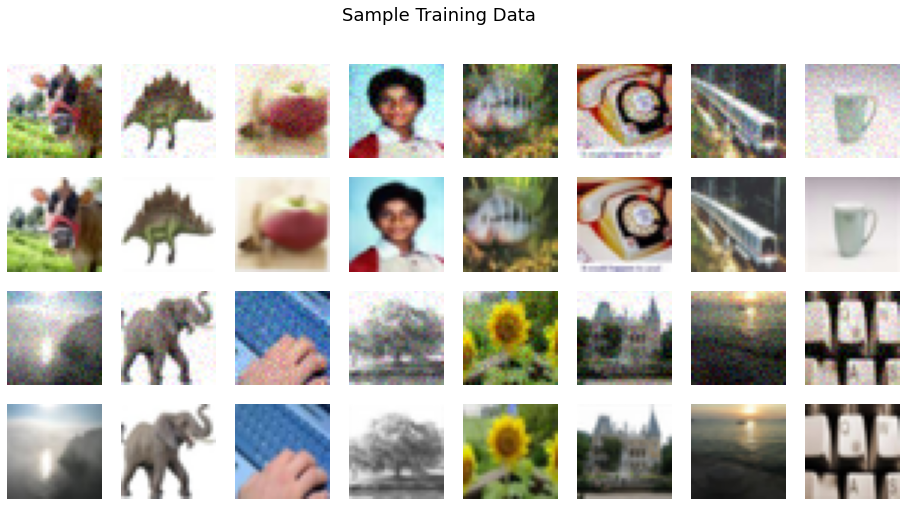

In [ ]:
rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(train_data_noisy[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(train_data_clean[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data for CIFAR-100 Dataset",fontsize=20)

plt.show()

### Define a Simple CNN Architecture

### General Function to include the convolution and deconvolution layers in our model architecture

In [ ]:
# Function to include the convolution layers in our model architecture
def conv_block(x, filters, kernel_size, strides=2):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Function to include the de-convolution layers in our model architecture
def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

### Function to denoise the images given to the model

In [ ]:
def denoising_autoencoder():
    den_inputs = Input(shape=(32, 32, 3), name='dae_input')
    conv_block1 = conv_block(den_inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3, 1)

    deconv_block1 = deconv_block(conv_block5, 256, 3)
    merge1 = Concatenate()([deconv_block1, conv_block3])
    deconv_block2 = deconv_block(merge1, 128, 3)
    merge2 = Concatenate()([deconv_block2, conv_block2])
    deconv_block3 = deconv_block(merge2, 64, 3)
    merge3 = Concatenate()([deconv_block3, conv_block1])
    deconv_block4 = deconv_block(merge3, 32, 3)

    final_deconv = Conv2DTranspose(filters=3,
                        kernel_size=3,
                        padding='same')(deconv_block4)

    den_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
    
    return Model(den_inputs, den_outputs, name='dae')

### Function Calling, Model Compilation and Training

In [ ]:
dae = denoising_autoencoder() # Function Calling
dae.compile(loss='mse', optimizer='adam') # Model Compilation

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True) # Save the best weights

# Training or fitting the model

dae.fit(train_data_noisy,
        train_data_clean,
        validation_data=(test_data_noisy, test_data_clean),
        epochs=5,
        batch_size=128,
        callbacks=[checkpoint])

Epoch 1/5
391/391 [==============================] - 499s 1s/step - loss: 0.0037 - val_loss: 0.0057

Epoch 00001: val_loss improved from inf to 0.00574, saving model to best_model.h5
Epoch 2/5
391/391 [==============================] - 494s 1s/step - loss: 0.0016 - val_loss: 0.0016

Epoch 00002: val_loss improved from 0.00574 to 0.00157, saving model to best_model.h5
Epoch 3/5
391/391 [==============================] - 497s 1s/step - loss: 0.0014 - val_loss: 0.0012

Epoch 00003: val_loss improved from 0.00157 to 0.00121, saving model to best_model.h5
Epoch 4/5
391/391 [==============================] - 495s 1s/step - loss: 0.0013 - val_loss: 0.0015

Epoch 00004: val_loss did not improve from 0.00121
Epoch 5/5
391/391 [==============================] - 495s 1s/step - loss: 0.0012 - val_loss: 0.0011

Epoch 00005: val_loss improved from 0.00121 to 0.00110, saving model to best_model.h5


### Save the model weights and predict the denoised images using model

In [ ]:
dae.load_weights('best_model.h5') # load the weights which we have saved in our previous section
test_data_denoised = dae.predict(test_data_noisy)  # Predict the output images using the trained model of best weights

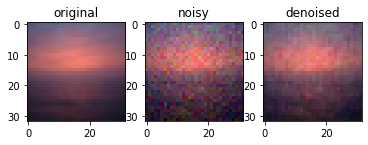

In [ ]:
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

### Evaluate the Model using MSE

In [ ]:
def mse(image_1, image_2):
    return np.square(np.subtract(image_1, image_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy) # MSE between initial and noisy test data
denoised_clean_mse = mse(test_data_denoised, test_data_clean) # MSE between noisy and cleaned test data given by model
noisy_clean_mse, denoised_clean_mse # Printing both the MSE values

(0.002373034333075446, 0.0011048389)

### Testing our DAE on CIFAR10 dataset

In [ ]:
(cifar10_train, _), (cifar10_test, _) = cifar10.load_data() # Load CIFAR-10 dataset

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
cifar10_train = cifar10_train.astype('float32') / 255.
cifar10_test = cifar10_test.astype('float32') / 255.
cifar10_train_noisy = add_noise_and_clip_data(cifar10_train, 0.5) # add noise to training dataset
cifar10_test_noisy = add_noise_and_clip_data(cifar10_test, 0.5) # add noise to testing dataset

In [ ]:
cifar10_test_denoised = dae.predict(cifar10_test_noisy) # prediction on CIFAR-10 Dataset

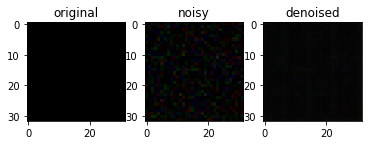

In [ ]:
idx = 6
plt.subplot(1,3,1)
plt.imshow(cifar10_test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(cifar10_test_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(cifar10_test_denoised[idx])
plt.title('denoised')
plt.show()

In [ ]:
clean_noisy = mse(cifar10_test, cifar10_test_noisy)
clean_denoised = mse(cifar10_test, cifar10_test_denoised)
clean_noisy, clean_denoised
print("The difference between the two images is:", clean_noisy-clean_denoised)

The difference between the two images is: 0.0007855786624293695


### Design a Encoder-Decoder Network with Skip Connections (U-Net Architecture)

In [ ]:
size = 32
channel = 3
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D

# Encoder Component of our autoencoder network 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder Component of our autoencoder network
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)

# Compiling the model 
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# Analyzing model summary
autoencoder.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_9/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'batch_normalization_9/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_10/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'batch_normalization_10/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a 

### Training or Fitting the Model

In [ ]:
# Fix the number of epochs and batch_size as hyperparameter
epochs = 25
batch_size = 256

history = autoencoder.fit(train_data_noisy,
                train_data_clean,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_data_noisy, test_data_clean)
               )

Epoch 1/25
196/196 [==============================] - 128s 644ms/step - loss: 0.6086 - val_loss: 0.5587
Epoch 2/25
196/196 [==============================] - 125s 640ms/step - loss: 0.5530 - val_loss: 0.5472
Epoch 3/25
196/196 [==============================] - 125s 640ms/step - loss: 0.5456 - val_loss: 0.5424
Epoch 4/25
196/196 [==============================] - 126s 645ms/step - loss: 0.5418 - val_loss: 0.5395
Epoch 5/25
196/196 [==============================] - 125s 636ms/step - loss: 0.5395 - val_loss: 0.5376
Epoch 6/25
196/196 [==============================] - 125s 639ms/step - loss: 0.5380 - val_loss: 0.5364
Epoch 7/25
196/196 [==============================] - 125s 637ms/step - loss: 0.5369 - val_loss: 0.5355
Epoch 8/25
196/196 [==============================] - 125s 636ms/step - loss: 0.5361 - val_loss: 0.5348
Epoch 9/25
196/196 [==============================] - 125s 637ms/step - loss: 0.5356 - val_loss: 0.5343
Epoch 10/25
196/196 [==============================] - 125s 638m

### Drawing the Loss vs Number of Epochs Curve 

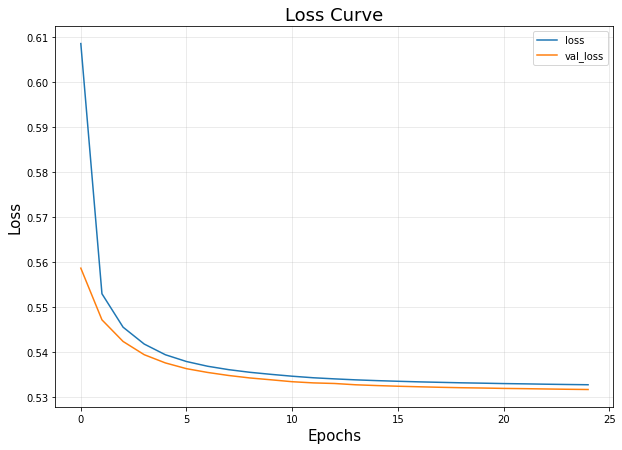

In [ ]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

# Adding Subplots
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

### Select few random test images

In [ ]:
# Number of images to be selected
num_imgs = 48
rand = np.random.randint(1, test_data_noisy.shape[0]-48) 

cifar_test_images = test_data_noisy[rand:rand+num_imgs] # slicing
cifar_test_denoised = autoencoder.predict(test_data_clean) # predict

### Visualize test images with their denoised images

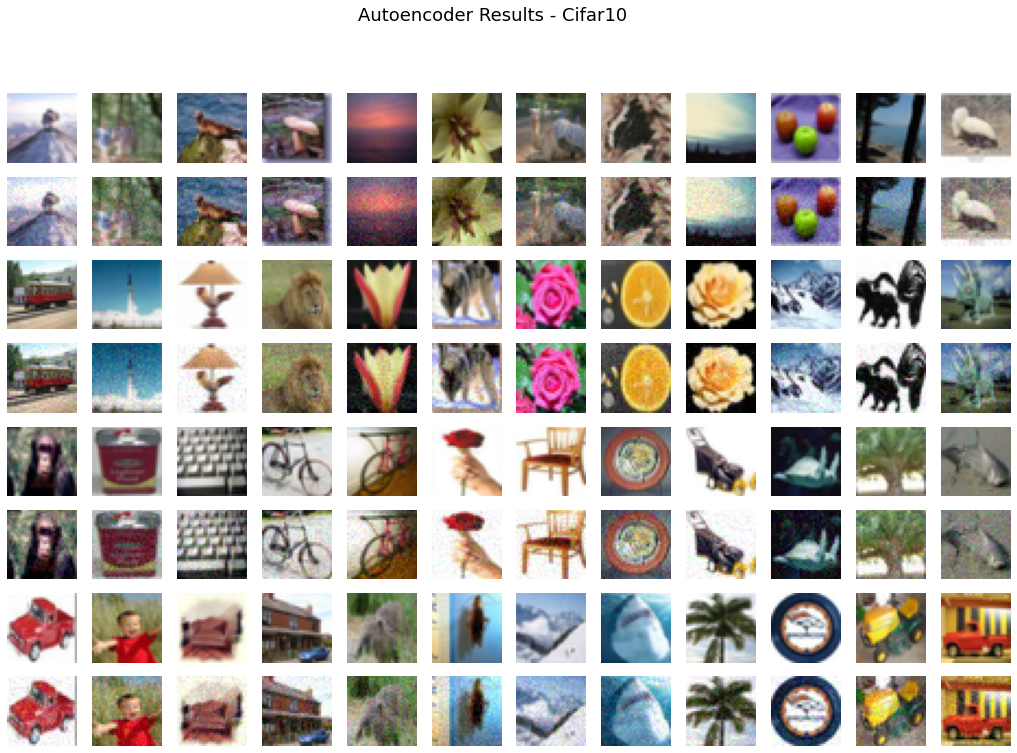

In [ ]:
rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_data_clean[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_data_noisy[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)

plt.show()

In [ ]:
def mse(data_1, data_2):
    return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)
noisy_clean_mse, denoised_clean_mse

(0.002373034333075446, 0.0011048389)

In [ ]:
cifar10_test_denoised = autoencoder.predict(cifar10_test_noisy)

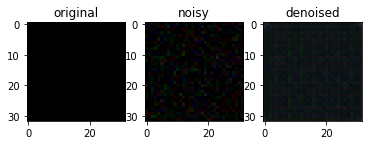

In [ ]:
idx = 6
plt.subplot(1,3,1)
plt.imshow(cifar10_test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(cifar10_test_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(cifar10_test_denoised[idx])
plt.title('denoised')
plt.show()

In [ ]:
clean_noisy = mse(cifar10_test, cifar10_test_noisy)
clean_denoised = mse(cifar10_test, cifar10_test_denoised)
clean_noisy, clean_denoised
print("The difference between the two images is:", clean_noisy-clean_denoised)

The difference between the two images is: -0.0046520704546548506
